# Demo of KG construction for reliability applications
This notebook is intended to show the steps required to construct the KG that include
- MBSE representation of the considered system
- Anomalies detected from numeric data
- Textual elements processed by TLP methods 

This notebook requires that:
* Neo4j desktop is installed in your machine
* A neo4j project is initialized with the corresponding Graph DBMS such that the bolt port is available
* the csv files are located in the correspoding folder; on MAC this can be found in this location:
  /"User"/Library/Application Support/Neo4j Desktop/Application/relate-data/dbmss/"dbms-ID"/import

## Steps to communicate with Neo4j 

1. Set import folder path for neo4j, this folder is used to store csv files (default is import folder)

2. Start neo4j desktop DBMS, set password if needed, this password will be used in Python driver to connect to DBMS database 
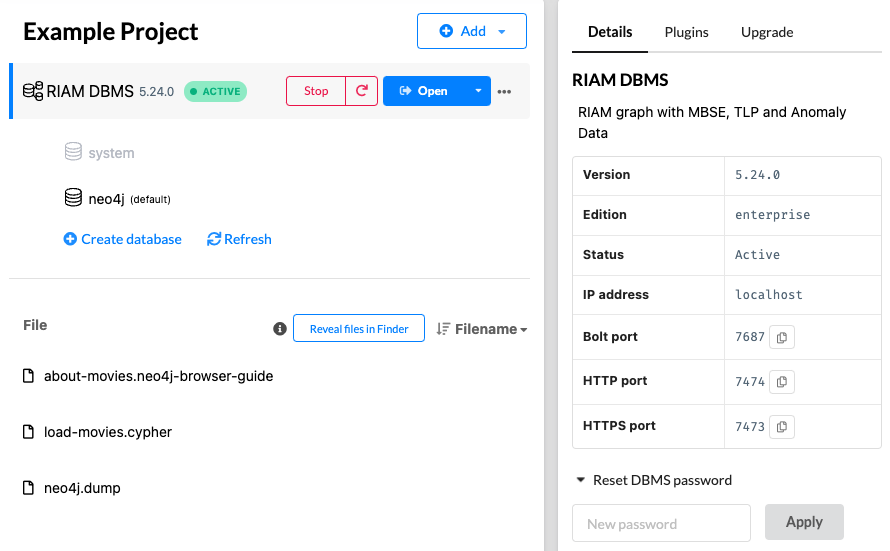
3. Once connection is established, python functions can be used to communicate with Neo4j

## Set import folder path for neo4j

In [1]:
import os
import re

def search_phrase(text, phrase):
    # Compile a regular expression pattern for the specific phrase
    pattern = re.compile(re.escape(phrase))

    # Search for the pattern in the text
    match = pattern.search(text)

    # Check if a match was found
    if match:
        return True
    else:
        return False

def set_neo4j_import_folder(config_file_path, import_folder_path):
    # Ensure the import directory exists
    if not os.path.exists(import_folder_path):
        os.makedirs(import_folder_path)

    found_dbms = False
    found_server = False
    with open(config_file_path, 'r') as file:
        lines = file.readlines()

    with open(config_file_path, 'w') as file:
        found_dbms = False
        found_server = False
        keyword = 'dbms.directories.import='
        for line in lines:
            # if line.startswith('dbms.directories.import='):
            #     file.write(f'dbms.directories.import={import_folder_path}\n')
            #     found_dbms = True
            # if search_phrase(line, keyword):
            #     file.write(f'dbms.directories.import={import_folder_path}\n')
            #     found_dbms = True
            if line.startswith('server.directories.import='):
                file.write(f'server.directories.import={import_folder_path}\n')
                found_server = True
            else:
                file.write(line)
        # if not found_dbms:
        #     file.write('\n')
        #     file.write(f'dbms.directories.import={import_folder_path}\n')
        if not found_server:
            file.write('\n')
            file.write(f'server.directories.import={import_folder_path}\n')

config_file_path = "/Users/wangc/Library/Application Support/Neo4j Desktop/Application/relate-data/dbmss/dbms-28cea4a5-ad08-4fed-94a1-70d44e297586/conf/neo4j.conf"
#  import folder path: /Users/wangc/Library/Application Support/Neo4j Desktop/Application/relate-data/dbmss/dbms-28cea4a5-ad08-4fed-94a1-70d44e297586/import/
import_folder_path = "/Users/wangc/projects/DACKAR/examples/KG_demo/"
set_neo4j_import_folder(config_file_path, import_folder_path)
print(f"Neo4j import folder set to: {import_folder_path}")

Neo4j import folder set to: /Users/wangc/projects/DACKAR/examples/KG_demo/


In [2]:
# Source: https://github.com/cj2001/bite_sized_data_science/tree/main
from neo4j import GraphDatabase

In [3]:
class Neo4jConnection:

    def __init__(self, uri, user, pwd):
        """init method

        Args:
            uri (str): # uri = "bolt://localhost:7687" for a single instance or uri = "neo4j://localhost:7687" for a cluster
            user (str): default to 'neo4j'
            pwd (str): password the the neo4j DBMS database (can be reset in neo4j Desktop app)
        """
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None

        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):
        """Close the python neo4j connection
        """
        if self.__driver is not None:
            self.__driver.close()

    def restart(self):
        """Restart the python neo4j connection
        """
        if self.__driver is not None:
            self.__driver.close()
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to restart the driver:", e)

    def create_node(self, label, properties):
        """Create a new graph node

        Args:
            label (str): node label will be used by neo4j
            properties (dict): node attributes
        """
        # label can be "mbse", "anomaly", "measure"
        with self.__driver.session() as session:
            session.execute_write(self._create_node, label, properties)

    @staticmethod
    def _create_node(tx, label, properties):
        """Create a new graph node

        Args:
            tx (obj): python neo4j active session that can be used to execute queries
            label (str): node label will be used by neo4j
            properties (dict): node attributes
        """
        query = f"MERGE (n:{label} {{ {', '.join([f'{k}: ${k}' for k in properties.keys()])} }})"
        # print(query)
        tx.run(query, **properties)


    def create_relation(self, l1, p1, l2, p2, lr, pr=None):
        """create graph relation

        Args:
            l1 (str): first node label
            p1 (dict): first node attributes
            l2 (str): second node label
            p2 (dict): second node attributes
            lr (str): relationship label
            pr (dict, optional): attributes for relationship. Defaults to None.
        """
        # label (l1/l2), properties (p1/p2), and relation label (lr), relation properties (pr)
        with self.__driver.session() as session:
            session.execute_write(self._create_relation, l1, p1, l2, p2, lr, pr)

    @staticmethod
    def _create_relation(tx, l1, p1, l2, p2, lr, pr):
        """create graph relation

        Args:
            tx (obj): python neo4j active session that can be used to execute queries
            l1 (str): first node label
            p1 (dict): first node attributes
            l2 (str): second node label
            p2 (dict): second node attributes
            lr (str): relationship label
            pr (dict, optional): attributes for relationship. Defaults to None.
        """
        if pr is not None:
            query = f"""
                MERGE (l1:{l1} {{ {', '.join([f'{k}:"{v}"' for k, v in p1.items()])} }})
                MERGE (l2:{l2} {{ {', '.join([f'{k}:"{v}"' for k, v in p2.items()])} }})
                MERGE (l1)-[r:{lr} {{ {', '.join([f'{k}: ${k}' for k in pr.keys()])} }} ]->(l2)
            """
            tx.run(query, **pr)
        else:
            query = f"""
                MERGE (l1:{l1} {{ {', '.join([f'{k}:"{v}"' for k, v in p1.items()])} }})
                MERGE (l2:{l2} {{ {', '.join([f'{k}:"{v}"' for k, v in p2.items()])} }})
                MERGE (l1)-[r:{lr}]->(l2)
            """
            # print(query)
            tx.run(query)

    def find_nodes(self, label, properties=None):
        """Find the node in neo4j graph database

        Args:
            label (str): node label
            properties (dict, optional): node attributes. Defaults to None.

        Returns:
            list: list of nodes
        """
        with self.__driver.session() as session:
            result = session.execute_read(self._find_nodes, label, properties)
            return result

    @staticmethod
    def _find_nodes(tx, label, properties):
        """Find the node in neo4j graph database

        Args:
            tx (obj): python neo4j active session that can be used to execute queries
            label (str): node label
            properties (dict, optional): node attributes. Defaults to None.

        Returns:
            list: list of nodes
        """
        if properties is None:
            query = f"MATCH (n:{label}) RETURN n"
        else:
            query = f"""MATCH (n:{label} {{ {', '.join([f'{k}:"{v}"' for k, v in properties.items()])} }}) RETURN n"""
        result = tx.run(query)
        values = [record.values() for record in result]
        return values

    def load_csv_for_nodes(self, file_path, label, attribute):
        """Load CSV file to create nodes

        Args:
            file_path (str): file path for CSV file, location is relative to 'dbms.directories.import' or 'server.directories.import' in neo4j.conf file
            label (str): node label
            attribute (dict): node attribute from the CSV column names
        """
        with self.__driver.session() as session:
            session.execute_write(self._load_csv_nodes, file_path, label, attribute)

    @staticmethod
    def _load_csv_nodes(tx, file_path, label, attribute):
        query = f"""
        LOAD CSV WITH HEADERS FROM 'file:///{file_path}' AS row
        MERGE (e:{label} {{ {', '.join([f'{k}:row.{v}' for k,v in attribute.items()])} }});
        """
        # print(query)
        tx.run(query)

    # Load csv function to create relations
    def load_csv_for_relations(self, file_path, l1, p1, l2, p2, lr, pr=None):
        """Load CSV file to create node relations

        Args:
            file_path (str): file path for CSV file, location is relative to 'dbms.directories.import' or 'server.directories.import' in neo4j.conf file
            l1 (str): first node label
            p1 (dict): first node attribute from the CSV column names
            l2 (str): second node label
            p2 (dict): second node attribute from the CSV column names
            lr (str): relationship label
            pr (dict, optional): of attributes for relation. Defaults to None.
        """
        # label (l1/l2), properties (p1/p2), and relation label (lr), relation properties (pr)
        with self.__driver.session() as session:
            session.execute_write(self._load_csv_for_relations, file_path, l1, p1, l2, p2, lr, pr)

    @staticmethod
    def _load_csv_for_relations(tx, file_path, l1, p1, l2, p2, lr, pr):
        if pr is not None:
            query = f"""
                LOAD CSV WITH HEADERS FROM 'file:///{file_path}' AS row
                MERGE (l1:{l1} {{ {', '.join([f'{k}:row.{v}' for k,v in p1.items()])} }})
                MERGE (l2:{l2} {{ {', '.join([f'{k}:row.{v}' for k,v in p2.items()])} }})
                MERGE (l1)-[r:{lr} {{ {', '.join([f'{k}: row.{v}' for k,v in pr.items()])} }} ]->(l2)
            """
            tx.run(query)
        else:
            query = f"""
                LOAD CSV WITH HEADERS FROM 'file:///{file_path}' AS row
                MERGE (l1:{l1} {{ {', '.join([f'{k}:row.{v}' for k,v in p1.items()])} }})
                MERGE (l2:{l2} {{ {', '.join([f'{k}:row.{v}' for k,v in p2.items()])} }})
                MERGE (l1)-[r:{lr}]->(l2)
            """
        # print(query)
        tx.run(query)

    def query(self, query, parameters=None, db=None):
        """User provided Cypher query statements for python neo4j driver to use to query database

        Args:
            query (str): user provided Cypher query statements
            parameters (dict, optional): dictionary that provide key/value pairs for query statement to use. Defaults to None.
            db (str, optional): name for database. Defaults to None.

        Returns:
            list: returned list of queried results.
        """

        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None

        try:
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response

    def reset(self):
        """Reset the database, delete all records, use it with care
        """
        with self.__driver.session() as session:
            session.execute_write(self._reset)

    @staticmethod
    def _reset(tx):
        query = 'MATCH (n) DETACH DELETE n;'
        tx.run(query)

    def get_all(self):
        """Get all records from database

        Returns:
            list: list of all records
        """
        with self.__driver.session() as session:
            result = session.execute_write(self._get_all)
            return result

    @staticmethod
    def _get_all(tx):
        query = 'MATCH (n) RETURN n;'
        result = list(tx.run(query))
        # result = [record.values() for record in result]
        return result

# uri = "bolt://localhost:7687" # for a single instance
uri = "neo4j://localhost:7687" # for a cluster
pwd = "123456789"

py2neo = Neo4jConnection(uri=uri, user='neo4j', pwd=pwd)

## Test Functions

In [4]:
# Test get_all function
result = py2neo.get_all()
print('Initial:\n', result)
# Test create_node function
py2neo.create_node('mbse', {'id':'cws'})
py2neo.create_node('mbse', {'id':'pump set'})
py2neo.create_node('mbse', {'id':'waterbox'})
py2neo.create_node('mbse', {'id':'pump 1'})
# Test find_nodes function
result = py2neo.find_nodes('mbse')
print('Find nodes:\n', result)
# Test query function
result = py2neo.query('MATCH (n) return n;')
print("Query results:\n", result)

result = py2neo.get_all()
print("Get all results:\n", result)
# Test reset function
py2neo.reset()
result = py2neo.get_all()
print("Get all results after reset:\n", result)

# Test restart function
py2neo.close()
py2neo.restart()
py2neo.create_node('mbse', {'id':'cws'})
result = py2neo.get_all()
print("Get all results after close and restart:\n", result)
# Test create_relation function
py2neo.reset()
data = {'mbse': [{'node':{'id':'cws'}, 'edge':[{'id':'pump'}, {'id':'waterbox'}]}, {'node':{'id':'pump'}, 'edge':[{'id':'pump1'}]}, {'node':{'id':'pump1'}, 'edge':[]} ]}
for l, nodes in data.items():
  for n in nodes:
    py2neo.create_node(l, n['node'])
    if len(n['edge']) != 0:
      for e in n['edge']:
        py2neo.create_relation(l, n['node'], l, e, 'consist')
result = py2neo.get_all()
print('Get all results for created nodes and relations:\n', result)


Initial:
 [<Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:36' labels=frozenset({'mbse'}) properties={'id': 'cws'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:37' labels=frozenset({'mbse'}) properties={'id': 'waterbox'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:38' labels=frozenset({'mbse'}) properties={'id': 'ice barrier'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:39' labels=frozenset({'mbse'}) properties={'id': 'travelling screen'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:40' labels=frozenset({'mbse'}) properties={'id': 'screen wash set'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:41' labels=frozenset({'mbse'}) properties={'id': 'pump set'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:42' labels=frozenset({'mbse'}) properties={'id': 'cooling tower'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110

In [5]:
# Test Load CSV function
py2neo.reset()
py2neo.load_csv_for_nodes('test_nodes.csv', 'MBSE', {'nodeId':'nodeId', 'label':'label', 'ID':'ID', 'type':'type'})
result = py2neo.get_all()
print(result)

[<Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:55' labels=frozenset({'MBSE'}) properties={'ID': 'body', 'label': 'OPM_pump', 'type': 'MBSE_linked_ent', 'nodeId': '8'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:56' labels=frozenset({'MBSE'}) properties={'ID': 'PM1', 'label': 'pump', 'type': 'entity', 'nodeId': '9'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:57' labels=frozenset({'MBSE'}) properties={'ID': 'I_2J6B8DXJ2WH0N_AR6M5HTA4X3SZ', 'label': 'pipe', 'type': 'LML_link', 'nodeId': '10'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:64' labels=frozenset({'MBSE'}) properties={'ID': 'V1', 'label': 'V1', 'type': 'entity_emb', 'nodeId': '11'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:65' labels=frozenset({'MBSE'}) properties={'ID': 'PM2', 'label': 'pump', 'type': 'entity', 'nodeId': '12'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:66' la

## Load MBSE nodes and edges via functions

### Load MBSE model node data

In [6]:
py2neo.reset()
file_path = 'test_nodes.csv'
label = 'MBSE'
attribute = {'nodeId':'nodeId', 'label':'label', 'ID':'ID', 'type':'type'}
py2neo.load_csv_for_nodes(file_path, label, attribute)

### Load MBSE model relationship data

In [7]:
file_path = 'test_edges.csv'
l1='MBSE'
p1={'nodeId':'sourceNodeId'}
l2='MBSE'
p2 ={'nodeId':'targetNodeId'}
lr = 'MBSE_link'
pr = {'prop':'type'}
py2neo.load_csv_for_relations(file_path, l1, p1, l2, p2, lr, pr)

### Load monitoring data

In [8]:
file_path = 'test_monit_vars.csv'
label = 'monitor_var'
attribute = {'nodeId':'varID'}
py2neo.load_csv_for_nodes(file_path, label, attribute)

### Load monitoring relationship data and link to MBSE model data

In [9]:
file_path = 'test_monit_vars.csv'
l1='monitor_var'
p1={'nodeId':'varID'}
l2='MBSE'
p2 ={'nodeId':'MBSE_ID'}
lr = 'monitoring'
pr = None
py2neo.load_csv_for_relations(file_path, l1, p1, l2, p2, lr, pr)

### Load anomaly detection data

In [10]:
file_path = 'test_AD.csv'
label = 'anomaly_detect'
attribute = {'nodeId':'AD_ID', 'type':'type'}
py2neo.load_csv_for_nodes(file_path, label, attribute)

### Load anomaly detection relation data and link to monitoring data

In [11]:
file_path = 'test_AD.csv'
l1='anomaly_detect'
p1={'nodeId':'AD_ID'}
l2='monitor_var'
p2 ={'nodeId':'var_ID'}
lr = 'input_from'
pr = None
py2neo.load_csv_for_relations(file_path, l1, p1, l2, p2, lr, pr)

### Load anomalies

In [12]:
file_path = 'test_anomalies.csv'
label = 'anomaly'
attribute = {'nodeId':'anom_ID', 'time_initial':'t_in', 'time_final':'t_fin'}
py2neo.load_csv_for_nodes(file_path, label, attribute)

### Load anomalies relation data and link to anomaly detection method

In [13]:
file_path = 'test_anomalies.csv'
l1='anomaly'
p1={'nodeId':'anom_ID'}
l2='anomaly_detect'
p2 ={'nodeId':'AD_ID'}
lr = 'detected_by'
pr = None
py2neo.load_csv_for_relations(file_path, l1, p1, l2, p2, lr, pr)

### Load MBSE nodes and edges via query statements

In [14]:
py2neo.reset()
query2 = """
LOAD CSV WITH HEADERS FROM 'file:////test_nodes.csv' AS row
MERGE (e:MBSE {nodeId: row.nodeId, label: row.label, ID: row.ID, type: row.type}) return row """

result = py2neo.query(query2)
print(result)

query3 = """
LOAD CSV WITH HEADERS FROM 'file:///test_edges.csv' AS row
MATCH (e:MBSE {nodeId: row.sourceNodeId})
MATCH (c:MBSE {nodeId: row.targetNodeId})
CREATE (e)-[:MBSE_link {prop:row.type}]->(c) """

result = py2neo.query(query3)
print(result)

[<Record row={'nodeId': '0', 'ID': 'C3', 'label': 'C3', 'type': 'entity_emb'}>, <Record row={'nodeId': '1', 'ID': 'cond1', 'label': 'condenser', 'type': 'entity'}>, <Record row={'nodeId': '2', 'ID': 'I_1PC9PKV4BTGV5_BMXNGD2MYES4D', 'label': 'pipe', 'type': 'LML_link'}>, <Record row={'nodeId': '3', 'ID': 'I_9YG45MX0QMK91_80WEVYKF2ZK18', 'label': 'pipe', 'type': 'LML_link'}>, <Record row={'nodeId': '4', 'ID': 'V2', 'label': 'V2', 'type': 'entity_emb'}>, <Record row={'nodeId': '5', 'ID': 'V3', 'label': 'V3', 'type': 'entity_emb'}>, <Record row={'nodeId': '6', 'ID': 'S3', 'label': 'level sensor', 'type': 'entity_emb'}>, <Record row={'nodeId': '7', 'ID': 'None', 'label': 'forebay', 'type': 'entity'}>, <Record row={'nodeId': '8', 'ID': 'body', 'label': 'OPM_pump', 'type': 'MBSE_linked_ent'}>, <Record row={'nodeId': '9', 'ID': 'PM1', 'label': 'pump', 'type': 'entity'}>, <Record row={'nodeId': '10', 'ID': 'I_2J6B8DXJ2WH0N_AR6M5HTA4X3SZ', 'label': 'pipe', 'type': 'LML_link'}>, <Record row={'nod

## Load monitoring vars and their link to MBSE nodes

In [15]:
query4 = """LOAD CSV WITH HEADERS FROM 'file:///test_monit_vars.csv' AS row
MERGE (v:monitor_var {nodeId: row.varID})
return row """
result = py2neo.query(query4)
print(result)

query5 = """LOAD CSV WITH HEADERS FROM 'file:///test_monit_vars.csv' AS row
MATCH (v:monitor_var {nodeId: row.varID})
MATCH (e:MBSE {nodeId: row.MBSE_ID})
CREATE (v)-[:monitoring]->(e) """
result = py2neo.query(query5)
print(result)

[<Record row={'varID': 'x_1', 'MBSE_ID': '9'}>, <Record row={'varID': 'x_2', 'MBSE_ID': '12'}>, <Record row={'varID': 'T_cond', 'MBSE_ID': '1'}>]
[]


## Load anomaly detection methods and their link to monitoring vars

In [16]:
query6 = """LOAD CSV WITH HEADERS FROM 'file:///test_AD.csv' AS row
MERGE (ad:anomaly_detect {nodeId: row.AD_ID, type: row.type})
return row"""
result = py2neo.query(query6)
print(result)

query7 = """LOAD CSV WITH HEADERS FROM 'file:///test_AD.csv' AS row
MATCH (ad:anomaly_detect {nodeId: row.AD_ID})
MATCH (v:monitor_var {nodeId: row.var_ID})
CREATE (ad)-[:input_from]->(v)"""
result = py2neo.query(query7)
print(result)

[<Record row={'type': 'matrix_profile', 'var_ID': 'x_1', 'AD_ID': '1'}>, <Record row={'type': 'matrix_profile', 'var_ID': 'x_2', 'AD_ID': '2'}>, <Record row={'type': 'matrix_profile', 'var_ID': 'T_cond', 'AD_ID': '3'}>, <Record row={'type': 'matrix_profile_ND', 'var_ID': 'x_1', 'AD_ID': '4'}>, <Record row={'type': 'matrix_profile_ND', 'var_ID': 'x_2', 'AD_ID': '4'}>]
[]


## Load detected anomalies and link to anomaly detection methods

In [17]:
query8 = """LOAD CSV WITH HEADERS FROM 'file:///test_anomalies.csv' AS row
MERGE (a:anomaly {nodeId: row.anom_ID, time_initial: row.t_in, time_final: row.t_fin})
return row """
result = py2neo.query(query8)
print(result)

query9 = """LOAD CSV WITH HEADERS FROM 'file:///test_anomalies.csv' AS row
MATCH (a:anomaly {nodeId: row.anom_ID})
MATCH (ad:anomaly_detect {nodeId: row.AD_ID})
CREATE (a)-[:detected_by]->(ad) """
result = py2neo.query(query9)
print(result)

[<Record row={'t_in': '1', 't_fin': '2', 'anom_ID': '1', 'AD_ID': '1'}>, <Record row={'t_in': '5.5', 't_fin': '6', 'anom_ID': '2', 'AD_ID': '2'}>, <Record row={'t_in': '8', 't_fin': '9.2', 'anom_ID': '3', 'AD_ID': '3'}>, <Record row={'t_in': '10', 't_fin': '10.5', 'anom_ID': '4', 'AD_ID': '4'}>, <Record row={'t_in': '6.8', 't_fin': '7.1', 'anom_ID': '5', 'AD_ID': '3'}>]
[]


In [18]:
query10 = """MATCH (n) RETURN n """
result = py2neo.query(query10)
print(result)

[<Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:0' labels=frozenset({'anomaly_detect'}) properties={'type': 'matrix_profile_ND', 'nodeId': '4'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:1' labels=frozenset({'anomaly'}) properties={'time_initial': '1', 'nodeId': '1', 'time_final': '2'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:2' labels=frozenset({'anomaly'}) properties={'time_initial': '5.5', 'nodeId': '2', 'time_final': '6'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:3' labels=frozenset({'anomaly'}) properties={'time_initial': '8', 'nodeId': '3', 'time_final': '9.2'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:4' labels=frozenset({'anomaly'}) properties={'time_initial': '10', 'nodeId': '4', 'time_final': '10.5'}>>, <Record n=<Node element_id='4:c8c63d22-e0c6-49ee-8110-b5874298c9e6:5' labels=frozenset({'anomaly'}) properties={'time_initial': '6.8', 'nodeId': 

In [19]:
py2neo.close()

### Load OPM model

In [20]:
import os, sys

cwd = os.getcwd()
pathToDACKAR   = os.path.join(cwd, '..', '..', 'src')
sys.path.append(pathToDACKAR)

from dackar.utils.opm.OPLparser import OPMobject
import networkx as nx

# Load CWS OPM model
OPM_entities = {}
OPMfile = os.path.join(pathToDACKAR, '..', 'opm_models', 'CWS.html')
CWS_OPM = OPMobject(OPMfile)
cws_opmGraph = CWS_OPM.returnGraph()
objectList_cws = CWS_OPM.returnObjectList()

OPM_entities['CWS'] = objectList_cws

# Load external centrifugal pump OPM model
OPM_model = CWS_OPM.returnsExternalLinks()[-1]
OPMfile = pathToDACKAR + '/../opm_models/' + OPM_model + '.html'

centPump_OPM = OPMobject(OPMfile)
centPump_opmGraph = centPump_OPM.returnGraph()
objectList_centPump = centPump_OPM.returnObjectList()

OPM_entities['centPump'] = objectList_centPump

Warming up PyWSD (takes ~10 secs)... took 2.1764049530029297 secs.


In [21]:
# Restructure Data
# Node: {NodeLabel: {AttributeLabel:Attribute}}
# Relation: Node1, Node2, Relation

for x, y, z in cws_opmGraph.edges:
  print(x, y, z)
for x in cws_opmGraph.nodes:
  print(x)

cws waterbox consists of
cws ice barrier consists of
cws travelling screen consists of
cws screen wash set consists of
cws pump set consists of
waterbox cooling tower feed
ice barrier travelling screen feed
travelling screen trash rake consists of
travelling screen trash rack consists of
screen wash set sw1 consists of
screen wash set sw2 consists of
pump set pump1 consists of
pump set pump2 consists of
sw1 scrwshfull changes
sw2 scrwshfull changes
pump1 centrifugalpumpfull changes
pump2 centrifugalpumpfull changes
delaware bay ice barrier feed
cws
waterbox
ice barrier
travelling screen
screen wash set
pump set
cooling tower
trash rake
trash rack
sw1
sw2
scrwshfull
pump1
pump2
centrifugalpumpfull
delaware bay
480v ac


### Load data into neo4j 

In [22]:
py2neo.restart()
py2neo.reset()
for x in cws_opmGraph.nodes:
  py2neo.create_node('mbse', {'id':x})

for x, y, z in cws_opmGraph.edges:
  py2neo.create_relation('mbse', {'id':x}, 'mbse', {'id':y}, 'mbse_link', {'type':z})

py2neo.close()